In [35]:
!pip install tqdm

In [36]:
from svd.incremental_svd import *
from svd.incremental_approsvd import *
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm, trange
import numpy as np

In [37]:
PATH = 'ml-100k/u.data'

n_users = 943
n_movies = 1682

In [38]:
def computeMAE(rating_pairs):
    n = rating_pairs.shape[0]
    total = 0
    for rt, rp in rating_pairs:
        total += abs(rt - rp)
    return total / float(n)

def computeRMSE(rating_pairs):
    n = rating_pairs.shape[0]
    total = 0
    for rt, rp in rating_pairs:
        total += (rt - rp) ** 2
    return np.sqrt(total / float(n))

def ratings2matrix(ratings):
    data = np.zeros((n_users, n_movies))
    for r in ratings:
        data[r[0]-1, r[1]-1] = r[2] # data[user_idx, movie_idx] = rating
    return data

def createRatingPairs(ratings_test, mat1, mat2, n1, n2):
    rating_pairs = []
    for r in ratings_test:
        if r[1] >= (n1 + n2): continue
        r1 = mat1[r[0]-1, r[1]-1]
        r2 = mat2[r[0]-1, r[1]-1]
        rating_pairs.append((r1, r2))
    return np.asarray(rating_pairs)

In [39]:
# the data has ratings for 943 users on 1682 movies
n_ratings = 100000

ratings = []
with open(PATH) as f:
    for i in range(n_ratings):
        line = f.readline()
        ratings.append(list(map(int, line.rstrip().split('\t'))))
ratings = np.asarray(ratings)

## CrossVaalidation

In [40]:
def Calculate(k, n1, n2, c1, c2):
      np.random.shuffle(ratings)
      kf = KFold()

      iSVD_totalRMSE = 0.
      ApproSVD_totalRMSE = 0.
      iSVD_totalMAE = 0.
      ApproSVD_totalMAE = 0.

      for train_indices, test_indices in tqdm(kf.split(ratings), total=kf.get_n_splits(), desc=f"k-{k}"):
            # separate ratings to train and test
            ratings_train = ratings[train_indices]
            ratings_test = ratings[test_indices]

            # create training matrix
            mat_train = ratings2matrix(ratings_train)

            # rank-k approximation of [B1, B2] based on Incremental ApproSVD
            mat_b1 = mat_train[:, :n1]
            mat_b2 = mat_train[:, n1:n1+n2]

            # colums sampling probabilities for B1
            nnz_b1 = np.count_nonzero(mat_b1)
            p1 = np.zeros(n1)
            for i in range(n1):
                  p1[i] = np.count_nonzero(mat_b1[:, i]) / float(nnz_b1)

            # colums sampling probabilities for B2
            nnz_b2 = np.count_nonzero(mat_b2)
            p2 = np.zeros(n2)
            for i in range(n2):
                  p2[i] = np.count_nonzero(mat_b2[:, i]) / float(nnz_b2)

            mat_hk = incrementalApproSVD(mat_b1, mat_b2, c1, c2, k, p1, p2)
            mat_orig = mat_train[:, :n1+n2]
            mat_ApproSVD = np.dot(np.dot(mat_hk, mat_hk.T), mat_orig)

            # best rank-k approximation of [B1, B2] based on truncated SVD
            mat_u, vec_s, mat_vt = ln.svd(mat_train[:, :n1+n2], full_matrices=False)
            mat_SVD = np.dot(np.dot(mat_u[:, :k], np.diag(vec_s[:k])), mat_vt[:k, :])

            # compute RMSE between SVD and ApproSVD
            rating_pairs = createRatingPairs(ratings_test, mat_SVD, mat_ApproSVD, n1, n2)
            ApproSVD_totalRMSE += computeRMSE(rating_pairs)
            ApproSVD_totalMAE  += computeMAE(rating_pairs)
            # rank-k approximation of [A1, A2] based on Incremental SVD
            mat_a1 = mat_train[:, :c1]
            mat_a2 = mat_train[:, c1:c1+c2]

            mat_u, mat_s, mat_vt = incrementalSVD(mat_a1, mat_a2, k)
            mat_iSVD = np.dot(np.dot(mat_u, mat_s), mat_vt)

            # best rank-k approximation of [A1, A2] based on truncated SVD
            mat_u, vec_s, mat_vt = ln.svd(mat_train[:, :c1+c2], full_matrices=False)
            mat_SVD = np.dot(np.dot(mat_u[:, :k], np.diag(vec_s[:k])), mat_vt[:k, :])

            # compute RMSE between SVD and iSVD
            rating_pairs = createRatingPairs(ratings_test, mat_SVD, mat_iSVD, c1, c2)
            iSVD_totalRMSE += computeRMSE(rating_pairs)
            iSVD_totalMAE += computeMAE(rating_pairs)
      return iSVD_totalRMSE, ApproSVD_totalRMSE, iSVD_totalMAE, ApproSVD_totalMAE


In [41]:
# reduced rank
k = 10

# number of original columns for Incremental ApproSVD
# B1: 900, B2: 100
n1 = 900
n2 = 100

# how many columns are evaluated? (n_movies=1682 is the maximum)
# A1: 500, A2: 50
c1 = 500
c2 = 50

iSVD_totalRMSEs = []
ApproSVD_totalRMSEs = []
iSVD_totalMAEs = []
ApproSVD_totalMAEs = []


ks = [10, 100, 200, 400] 
for i in tqdm(range(4), total=4, desc="Variasi K"):
    iSVDRMSE, ApproSVDRMSE, iSVDMAE, ApproSVDMAE = Calculate(ks[i], n1, n2, c1, c2)
    iSVD_totalRMSEs.append(iSVDRMSE)
    ApproSVD_totalRMSEs.append(ApproSVDRMSE)
    iSVD_totalMAEs.append(iSVDMAE)
    ApproSVD_totalMAEs.append(ApproSVDMAE)

In [42]:
print('Incremental SVD      vs. truncated SVD:', iSVD_totalRMSE / 5.)
print('Incremental ApproSVD vs. truncated SVD:', ApproSVD_totalRMSE / 5.)

Incremental SVD      vs. truncated SVD: 0.15407386969272938
Incremental ApproSVD vs. truncated SVD: 0.3057662502157522


In [43]:
iSVD_totalMAEs

[0.1612605822214996,
 0.49479264591773703,
 0.5050872727747611,
 0.3333844247929389]

In [45]:
import matplotlib.pyplot as plt 
import numpy as np 
import math

In [48]:
X = np.arange(0, 400, 10)

Plot after re-sizing: 


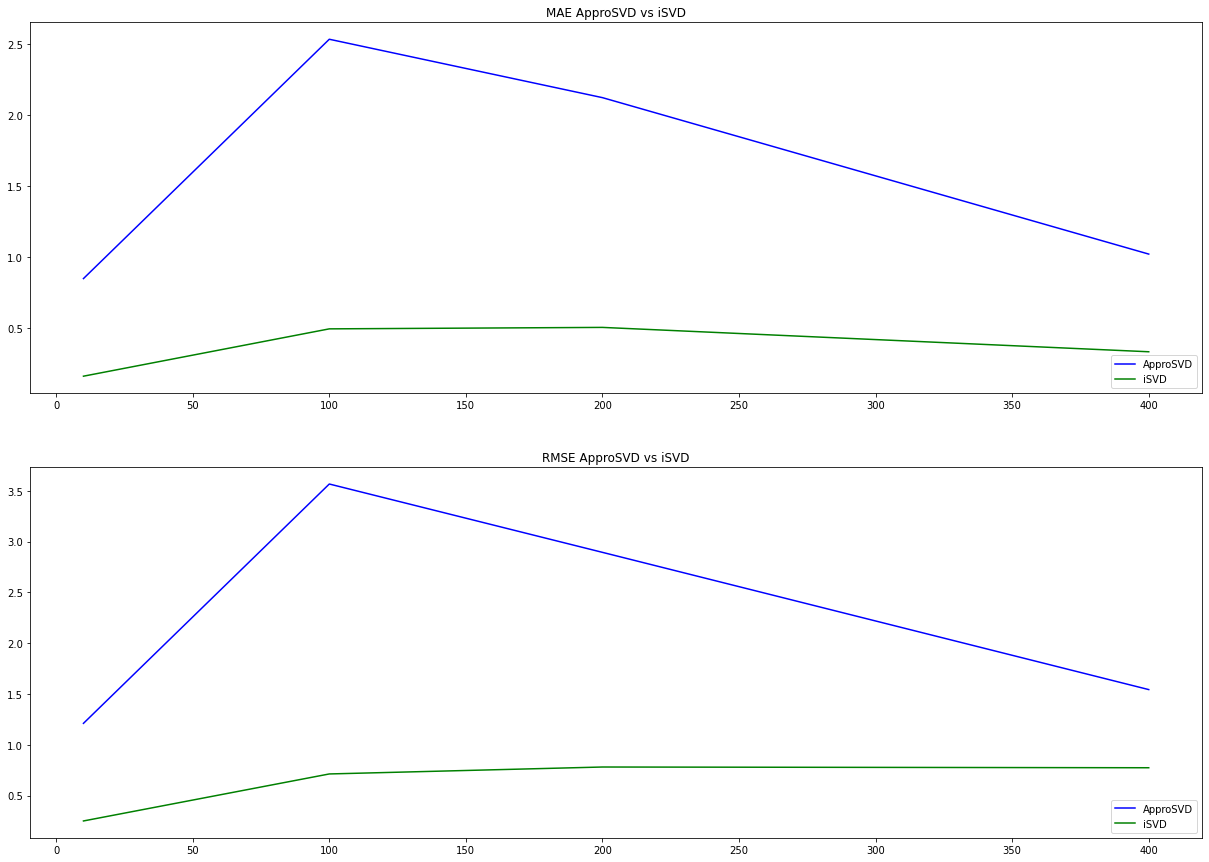

In [62]:
figure, axis = plt.subplots(2, 1) 

axis[0].set_title("MAE ApproSVD vs iSVD") 
axis[0].plot(ks, ApproSVD_totalMAEs, color='b', label="ApproSVD") 
axis[0].plot(ks, iSVD_totalMAEs, color='g', label="iSVD")  
axis[0].legend(["ApproSVD", "iSVD"], loc ="lower right") 

axis[1].set_title("RMSE ApproSVD vs iSVD") 
axis[1].plot(ks, ApproSVD_totalRMSEs, color='b', label="ApproSVD")   
axis[1].plot(ks, iSVD_totalRMSEs, color='g', label="iSVD")  
axis[1].legend(["ApproSVD", "iSVD"], loc ="lower right") 

# plotting a line plot after changing it's width and height 
 
figure.set_figwidth(21) 
figure.set_figheight(15) 
  
print("Plot after re-sizing: ")  
plt.show() 